# Peter og Ulven: Introduktion til Forstærkningslæring

I denne tutorial vil vi lære, hvordan man anvender forstærkningslæring på et problem med ruteplanlægning. Scenariet er inspireret af [Peter og Ulven](https://en.wikipedia.org/wiki/Peter_and_the_Wolf), et musikalsk eventyr af den russiske komponist [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Det er en historie om den unge pioner Peter, der modigt forlader sit hus og går ud til lysningen i skoven for at jage ulven. Vi vil træne maskinlæringsalgoritmer, der kan hjælpe Peter med at udforske det omkringliggende område og opbygge et optimalt navigationskort.

Lad os først importere en række nyttige biblioteker:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Oversigt over Forstærkningslæring

**Forstærkningslæring** (RL) er en læringsteknik, der giver os mulighed for at lære en optimal adfærd for en **agent** i et bestemt **miljø** ved at udføre mange eksperimenter. En agent i dette miljø bør have et **mål**, som er defineret af en **belønningsfunktion**.

## Miljøet

For enkelhedens skyld, lad os forestille os, at Peters verden er et kvadratisk bræt med størrelsen `bredde` x `højde`. Hver celle på dette bræt kan enten være:
* **jord**, som Peter og andre væsener kan gå på
* **vand**, som man selvfølgelig ikke kan gå på
* **et træ** eller **græs** - et sted, hvor man kan tage en pause
* **et æble**, som repræsenterer noget, Peter ville blive glad for at finde for at kunne spise
* **en ulv**, som er farlig og bør undgås

For at arbejde med miljøet vil vi definere en klasse kaldet `Board`. For ikke at gøre denne notesbog for rodet, har vi flyttet al kode, der arbejder med brættet, til et separat modul kaldet `rlboard`, som vi nu vil importere. Du kan kigge ind i dette modul for at få flere detaljer om implementeringens interne funktioner.


In [2]:
from rlboard import *

Lad os nu oprette et tilfældigt bræt og se, hvordan det ser ud:


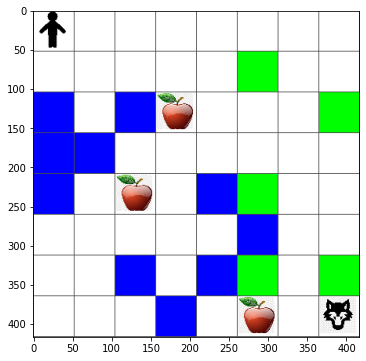

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Handlinger og Politik

I vores eksempel er Peters mål at finde et æble, mens han undgår ulven og andre forhindringer. For at opnå dette kan han i princippet gå rundt, indtil han finder et æble. Derfor kan han på enhver position vælge mellem følgende handlinger: op, ned, venstre og højre. Vi vil definere disse handlinger som en ordbog og knytte dem til par af tilsvarende koordinatændringer. For eksempel vil bevægelse mod højre (`R`) svare til et par `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Strategien for vores agent (Peter) er defineret af en såkaldt **politik**. Lad os se på den enkleste politik kaldet **tilfældig vandring**.

## Tilfældig vandring

Lad os først løse vores problem ved at implementere en strategi for tilfældig vandring.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Lad os udføre tilfældig gang-eksperimentet flere gange og se det gennemsnitlige antal trin taget:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Belønningsfunktion

For at gøre vores politik mere intelligent, skal vi forstå, hvilke træk der er "bedre" end andre.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Byg en Q-Table, eller en multidimensionel array. Da vores spillebræt har dimensionerne `width` x `height`, kan vi repræsentere Q-Table med en numpy-array med formen `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Overfør Q-tabellen til plotfunktionen for at visualisere tabellen på brættet:


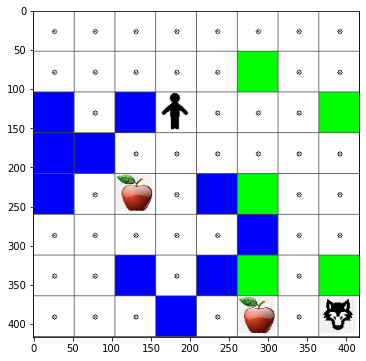

In [9]:
m.plot(Q)

## Essensen af Q-Learning: Bellman-ligning og læringsalgoritme

Skriv en pseudokode for vores læringsalgoritme:

* Initialiser Q-Tabellen Q med ens værdier for alle tilstande og handlinger
* Sæt læringsraten $\alpha\leftarrow 1$
* Gentag simuleringen mange gange
   1. Start fra en tilfældig position
   1. Gentag
        1. Vælg en handling $a$ i tilstand $s$
        2. Udfør handlingen ved at bevæge dig til en ny tilstand $s'$
        3. Hvis vi støder på en slutspil-betingelse, eller den samlede belønning er for lille - afslut simuleringen  
        4. Beregn belønningen $r$ i den nye tilstand
        5. Opdater Q-Funktionen i henhold til Bellman-ligningen: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Opdater den samlede belønning og reducer $\alpha$.

## Udnyttelse vs. Udforskning

Den bedste tilgang er at balancere mellem udforskning og udnyttelse. Efterhånden som vi lærer mere om vores miljø, vil vi være mere tilbøjelige til at følge den optimale rute, men samtidig vælge den uudforskede vej en gang imellem.

## Python-implementering

Nu er vi klar til at implementere læringsalgoritmen. Før det har vi også brug for en funktion, der kan konvertere vilkårlige tal i Q-Tabellen til en vektor af sandsynligheder for de tilsvarende handlinger:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Vi tilføjer en lille mængde `eps` til den oprindelige vektor for at undgå division med 0 i det indledende tilfælde, hvor alle komponenter i vektoren er identiske.

Den faktiske læringsalgoritme, som vi vil køre i 5000 eksperimenter, også kaldet **epoker**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Efter udførelsen af denne algoritme bør Q-Tabellen opdateres med værdier, der definerer attraktiviteten af forskellige handlinger på hvert trin. Visualiser tabellen her:


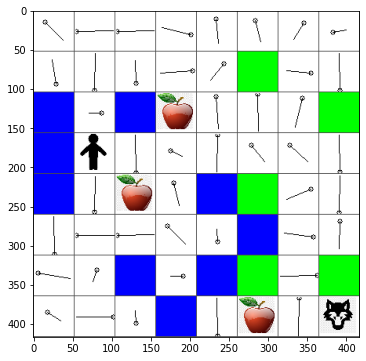

In [12]:
m.plot(Q)

## Kontrol af politikken

Da Q-Tabellen angiver "attraktiviteten" af hver handling i hver tilstand, er det ret nemt at bruge den til at definere den effektive navigation i vores verden. I det enkleste tilfælde kan vi blot vælge den handling, der svarer til den højeste værdi i Q-Tabellen:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Hvis du prøver koden ovenfor flere gange, vil du måske bemærke, at den nogle gange bare "hænger", og du er nødt til at trykke på STOP-knappen i notebooken for at afbryde den.

> **Opgave 1:** Ændr `walk`-funktionen, så den begrænser den maksimale længde af stien til et bestemt antal trin (for eksempel 100), og se koden ovenfor returnere denne værdi fra tid til anden.

> **Opgave 2:** Ændr `walk`-funktionen, så den ikke vender tilbage til steder, hvor den allerede har været tidligere. Dette vil forhindre `walk` i at gentage sig selv, men agenten kan stadig ende med at være "fanget" på et sted, hvor den ikke kan slippe væk.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


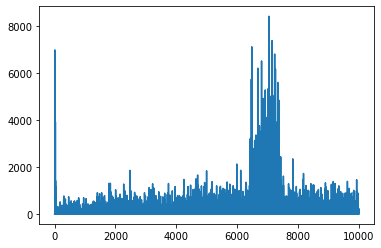

In [15]:
plt.plot(lpath)

Det, vi ser her, er, at den gennemsnitlige stibane først blev længere. Dette skyldes sandsynligvis, at når vi ikke ved noget om miljøet, har vi en tendens til at ende i dårlige tilstande, som vand eller ulve. Efterhånden som vi lærer mere og begynder at bruge denne viden, kan vi udforske miljøet i længere tid, men vi ved stadig ikke præcist, hvor æblerne er.

Når vi har lært nok, bliver det lettere for agenten at nå målet, og stibanen begynder at blive kortere. Dog er vi stadig åbne for udforskning, så vi afviger ofte fra den bedste sti og undersøger nye muligheder, hvilket gør stibanen længere end optimal.

Noget andet, vi observerer på denne graf, er, at stibanen på et tidspunkt steg pludseligt. Dette indikerer den stokastiske natur af processen, og at vi på et tidspunkt kan "ødelægge" Q-Table-koefficienterne ved at overskrive dem med nye værdier. Dette bør ideelt set minimeres ved at reducere læringsraten (dvs. mod slutningen af træningen justerer vi kun Q-Table-værdierne med en lille værdi).

Generelt er det vigtigt at huske, at succes og kvaliteten af læringsprocessen afhænger betydeligt af parametre som læringsrate, læringsrate-nedgang og diskonteringsfaktor. Disse kaldes ofte **hyperparametre** for at skelne dem fra **parametre**, som vi optimerer under træningen (f.eks. Q-Table-koefficienter). Processen med at finde de bedste hyperparameterværdier kaldes **hyperparameteroptimering**, og det fortjener et separat emne.


## Øvelse
#### En Mere Realistisk Verden for Peter og Ulven

I vores situation kunne Peter bevæge sig rundt næsten uden at blive træt eller sulten. I en mere realistisk verden skal han sætte sig ned og hvile fra tid til anden og også sørge for at spise. Lad os gøre vores verden mere realistisk ved at implementere følgende regler:

1. Ved at bevæge sig fra et sted til et andet mister Peter **energi** og får noget **træthed**.
2. Peter kan få mere energi ved at spise æbler.
3. Peter kan slippe af med træthed ved at hvile under træet eller på græsset (dvs. gå ind på en brætposition med et træ eller græs - grøn mark).
4. Peter skal finde og dræbe ulven.
5. For at dræbe ulven skal Peter have bestemte niveauer af energi og træthed, ellers taber han kampen.

Modificér belønningsfunktionen ovenfor i henhold til spillets regler, kør forstærkningslæringsalgoritmen for at lære den bedste strategi til at vinde spillet, og sammenlign resultaterne af tilfældig gang med din algoritme med hensyn til antal spil vundet og tabt.

> **Note**: Du kan være nødt til at justere hyperparametre for at få det til at fungere, især antallet af epoker. Fordi spillets succes (kampen mod ulven) er en sjælden begivenhed, kan du forvente en meget længere træningstid.



---

**Ansvarsfraskrivelse**:  
Dette dokument er blevet oversat ved hjælp af AI-oversættelsestjenesten [Co-op Translator](https://github.com/Azure/co-op-translator). Selvom vi bestræber os på nøjagtighed, skal du være opmærksom på, at automatiserede oversættelser kan indeholde fejl eller unøjagtigheder. Det originale dokument på dets oprindelige sprog bør betragtes som den autoritative kilde. For kritisk information anbefales professionel menneskelig oversættelse. Vi påtager os intet ansvar for misforståelser eller fejltolkninger, der måtte opstå som følge af brugen af denne oversættelse.
